**PRAKHAR BHARDWAJ**

**ANDREW ID - prakharb**

## Question 5: Extra Credit (15 points)

For extra credit, we will implement a smarter form of image blending, where seams are minimized. This can be used to handle exposure differences between stitches images, correct for motion blur, and even act as a photoshop healing tool. For examples in photo stitching, see [this link](http://www.cs.jhu.edu/~misha/Code/SMG/) or [this link](http://www.cs.jhu.edu/~misha/Code/DMG/Version4.5/).

### 5.1 (15 points)

In this section we will implement __Poisson Image Stitching__ \[perez2003poisson\] which can be used to create seamless photo montages. 

|<img align="center" src="figure/poisson_stitching.png" width="500">|
|:--:|
|Fig 5.1 Example of Possion image stitching.|

Write a function called $\texttt{poisson_blend(background,foreground,mask)}$ which takes 3 equal sized images (background and foreground as RGB, mask as binary) and solves the Poisson equation, using gradients from foreground and boundary conditions from the background. 

**The problem will be manually graded.** Please include results from the $\texttt{(fg1,bg1,mask1)}$ images in your write-up.

*Hint:* The basic idea behind Poisson Image Stitching is to setup a linear system $A x = b$ where each row of $A$ is the gradient operator for the image pixel mask (e.g. 4 for each pixel, and -1 +1 for it's 4 neighbors), while the row in $b$ contains known gradients from the foreground. Additional rows in $A$ are pixels on the boundary, which have known values, stored in $b$. Solving for $x$ then gives you pixel values for the entire masked patch. This is done for each image channel seperately. See [this page](http://www.ctralie.com/Teaching/PoissonImageEditing/) or [this page](http://cs.brown.edu/courses/csci1950-g/results/proj2/pdoran/index.html) if you need more information. 

C:\Users\CH\AppData\Local\Temp\ipykernel_11132\3578618097.py:52: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.atleast_3d(mask_img).astype(np.float) / 255.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


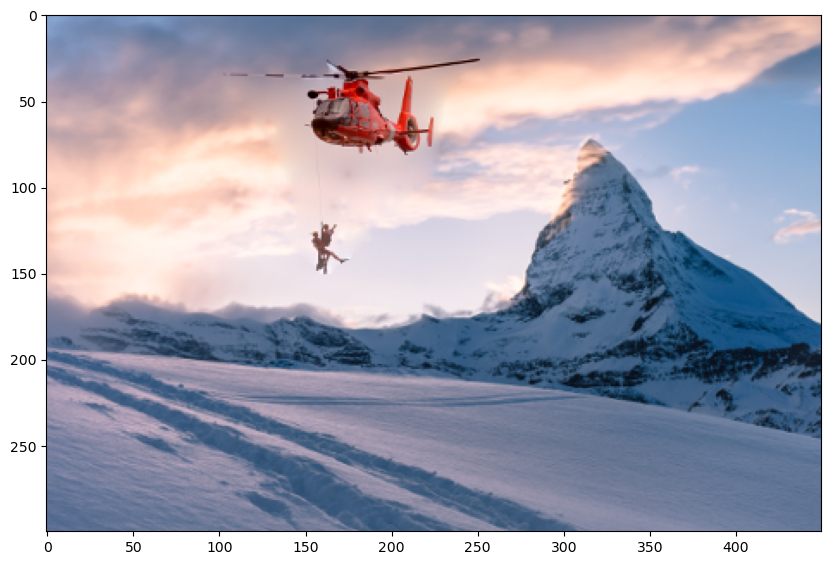

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.sparse import linalg as linalg
from scipy.sparse import lil_matrix as lil_matrix


def image_edge(index, mask):
    if (mask[index] == 1) == False: 
        return False
    for pt in surr_(index): 
        if (mask[pt] == 1) == False: return True
    return False

def surr_(index):
    i,j = index
    return [(i+1,j),(i-1,j),(i,j+1),(i,j-1)]

def poisson_sparse_matrix(points):
    A = lil_matrix((len(points),len(points)))
    for i,index in enumerate(points):
        A[i,i] = 4
        for x in surr_(index):
            if x not in points: continue
            j = points.index(x)
            A[i,j] = -1
    return A

def poisson_blend(background, foreground, mask):
    nonzero = np.nonzero(mask)
    indicies = list(zip(nonzero[0], nonzero[1]))
    A = poisson_sparse_matrix(indicies)
    b = np.zeros(len(indicies)) 
    for i,index in enumerate(indicies):
        j,k = index
        b[i] = (4 * background[j,k]) - (1 * background[j+1, k]) - (1 * background[j-1, k]) - (1 * background[j, k+1]) - (1 * background[j, k-1])      
        if (image_edge(index,mask) == True) == 1:
            for pt in surr_(index):
                if (mask[pt] == 1) == False:
                    b[i] += foreground[pt]

    x = linalg.cg(A, b) 
    composite = np.copy(foreground).astype(int)
    for i,index in enumerate(indicies):
        composite[index] = x[0][i]
    return composite

background_img = cv2.cvtColor(cv2.imread('data/fg1.png'), cv2.COLOR_BGR2RGB)
foreground_img = cv2.cvtColor(cv2.imread('data/bg1.png'), cv2.COLOR_BGR2RGB)
mask_img = cv2.cvtColor(cv2.imread('data/mask1.png'), cv2.COLOR_BGR2GRAY)

mask = np.atleast_3d(mask_img).astype(np.float) / 255. 
mask[mask != 1] = 0  
mask = mask[:,:,0]
channels = background_img.shape[-1]

stack_result = [poisson_blend(background_img[:,:,i], foreground_img[:,:,i], mask) for i in range(channels)]
result = cv2.merge(stack_result)
plt.rcParams['figure.figsize'] = (10, 10)
plt.imshow(result)
plt.show()